<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DECam HiTS Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: February 2, 2024<br>
LSST Science Piplines version: w_2024_04<br>
Container Size: Medium <br>

# DM-41519: ApPipeWithFakes on DECam HiTS with Pre Convolution, November 2023

## Current Run Details
DECam HiTS with convolution mode set to preconvolution, compared with February 2023 Pre Convolution run.

* Used weekly `w_2023_47` with preconvolution.
* Working directory on USDF with bps logs, pipelines, etc. is `/project/elhoward/repo-main-logs/DM-41519`
* Templates are in `u/elhoward/DM-38243/templates`
* Final processing of DECam HiTS is in `u/elhoward/DM-41519/HiTS-fakes-precon`
* Postgres schema is `elhoward_dm41519_hits_hits_appipewithfakes`

For `bps_ApPipe_DM-41519.yaml`:
```
inCollection: u/elhoward/DM-38243/templates,refcats/DM-39298
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector NOT IN (2, 61) AND exposure>400000"
```
Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Analysis Details

The run had a not insignificant amount of failures. 297 quanta failed (278 in calibrate, 2 in retrieveTemplateWithFakes, 4 in subtractScoreImagesWithFakes, and 13 in transformDiaSrcCatWithFakes) resulting in an additional 2278 quanta being unable to run. The resulting analysis is heavily influenced by this, as well as the issue with fakes matching we saw widh DM-37699.

* Good DIA Objects increased slightly, All DIA Objects decreased. Good DIA Sources increased slightly, All DIA Sources decreased.
* * Some detectors lost much more good DIA objects than others. This is possibly due to the failures.
* * Significant increase in DIA sources around 0 nJy PSF Flux. Tot Flux has a decrease around 0 nJy and an increase around 1000 nJy but otherwise the shape is similar to the previous plot.
* No fakes analysis due to issues with fakes matching.
* SNR distributions have a similar shape and spread as the previous pre con run but do not have as many sources due to the quanta failures.

## Previous Runs
- [DM-37698: ApPipeWithFakes on DECam HiTS with Preconvolution, February 2023](.DM-37698-AP-DECam-HiTS-Feb2023-PreCon-Fakes.ipynb)
- [DM-37696: ApPipeWithFakes on DECam HiTS with Auto Convolution, February 2023](.DM-37696-AP-DECam-HiTS-Feb2023-AutoCon.ipynb)
- [DM-37694: ApPipeWithFakes on DECam HiTS, February 2023](.DM-37694-AP-DECam-HiTS-Feb2023.ipynb)
- [DM-35284: ApPipeWithFakes on DECam HiTS, November 2022](./DM-35284-AP-DECam-HiTS-Nov2022.ipynb) (Run has been removed from APDB)
- [DM-35284: ApPipeWithFakes on DECam HiTS, November 2022](./DM-35284-AP-DECam-HiTS-Nov2022.ipynb) (Data has since been corrupted)
- [DM-36024: ApPipeWithFakes on DECam HiTS, October 2022](./DM-36024-AP-DECam-HiTS-Oct2022.ipynb) (Run has been removed from APDB)

## Table of Contents

1. [Imports, Helper Functions, and Loading](#section_1)
2. [DiaObject and DiaSources analysis](#section_2)
3. [Comparisons to previous processing run](#section_3)
4. [Separating the fake sources from the real sources](#section_4)
5. [Fakes completeness analysis](#section_5)
6. [SNR distributions](#section_6)

## 1. <a id="section_1">Imports, Helper Functions, and Loading</a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import lsst.daf.butler as dafButler
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import apdb

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import functools
import operator
from IPython.display import Image, display

import lsst.afw.display as afwDisplay
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

### Helper Functions

In [2]:
badFlagList=['base_PixelFlags_flag_bad',
             'base_PixelFlags_flag_suspect',
             'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_interpolated',
             'base_PixelFlags_flag_interpolatedCenter',
             'base_PixelFlags_flag_edge',
             ]

In [3]:
def flagTables(sourceTable, objectTable, badFlagList, butler, instrument=None):
    """Apply flag filters to a DIA Source and a DIA Object table.
    
    Parameters
    ----------
    sourceTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Sources from an APDB.
    objectTable : `pandas.core.frame.DataFrame`
        Pandas dataframe with DIA Objects from an APDB.
    badFlagList :  `list`
        Names of flags presumed to each indicate a DIA Source is garbage.
     instrument : `str`
        Default is 'DECam'
    Returns
    -------
    sourceTableFlags : `pandas.core.frame.DataFrame`
        Dataframe containing all DIA Sources from sourceTable
        with flags expanded.
    goodSrcFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Sources from sourceTable
        with no bad flags, with all flags expanded.
    goodObjFlags : `pandas.core.frame.DataFrame`
        Dataframe containing only DIA Objects from ObjectTable
        with no bad flags, with all flags expanded.
    """
    from lsst.pipe.base import Instrument
    
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = Instrument.make_default_dimension_packer(data_id=instrumentDataId,
                                                      is_exposure=False)
    dataId = packer.unpack(sourceTable.ccdVisitId)
    
    sourceTable['visit'] = dataId['visit']
    sourceTable['detector'] = dataId['detector']
    sourceTable['instrument'] = instrument
    
    config = TransformDiaSourceCatalogConfig()
    unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
    
    flagValues = unpacker.unpack(sourceTable['flags'], 'flags')
    flagTable = pd.DataFrame(flagValues, index=sourceTable.index)
    
    sourceTableFlags = pd.merge(sourceTable, flagTable, left_index=True, right_index=True)
    badFlags = [sourceTableFlags[flag] for flag in badFlagList]
    
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    
    goodSrcFlags = sourceTableFlags.loc[noFlagFilter]
    
    goodObjIds = set(sourceTableFlags.loc[noFlagFilter, 'diaObjectId'])
    goodObjFlags = objectTable.loc[objectTable['diaObjectId'].isin(goodObjIds)]
    
    return goodSrcFlags.reset_index(drop=True), goodObjFlags.reset_index(drop=True), flagTable, sourceTableFlags

In [4]:
def spatial_flag_plot(df, df2, flagName1, flagName2=None, operator=None, plotFlagged=True, 
                      plotUnFlagged=True, title='', title2=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) | (df2[flagName2]))
            labelTrue2 = flagName1 + ' \nor ' + flagName2
            labelFalse2 = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
            
            flagFilter2 = ((df2[flagName1]) & (df2[flagName2]))
            labelTrue2 = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse2 = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
        
        flagFilter2 = (df2[flagName1])
        labelTrue2 = flagName1
        labelFalse2 = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    flagFilterInverse2 = ~flagFilter2
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'dec'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
        scatterFlagged = ax2.scatter(df2.loc[flagFilter2, 'ra'], df2.loc[flagFilter2, 'dec'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'dec'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        scatterUnflagged = ax2.scatter(df2.loc[flagFilterInverse2, 'ra'], df2.loc[flagFilterInverse2, 'dec'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
        
    print(f'--{month} {year}--')
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title)
    
    print(f'--{month_old} {year_old}--')
    print('Flagged sources: {0}'.format(len(df2.loc[flagFilter2, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df2.loc[flagFilterInverse2, 'ra'])))
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Dec (deg)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_title(title2)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    plt.setp(ax2, xlim=xlim, ylim=ylim)
    plt.suptitle(f'Flagged vs Unflagged Sources (with fakes)')

### Loading Data

In [5]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'DECam'
skymap = 'decam_rings_v1'

fakeStatus = 'with fakes'

dmnum = '41519'
collections = f'u/elhoward/DM-{dmnum}/HiTS-fakes-precon'
schema = f'elhoward_dm{dmnum}_hits_appipewithfakes'
month = 'November (Pre Con)'
year = '2023'

dmnum_old = '37698'
collections_old = f'u/elhoward/DM-{dmnum_old}/HiTS-fakes'
schema_old = f'elhoward_dm{dmnum_old}_hits_appipewithfakes'
month_old = 'February (Pre Con)'
year_old = '2023'

collectionsList = [collections,collections_old]

apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

In [6]:
with apdbQuery.connection as connection:
    srcTable = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "dec", "ccdVisitId", \
                                 "psfFlux" AS "psFlux", "psfFluxErr" AS "psFluxErr", \
                                 "scienceFlux" AS "totFlux", "scienceFluxErr" AS "totFluxErr", "snr", \
                                 "flags", "band" AS "filterName" \
                                 FROM "{}"."DiaSource";'.format(schema), connection)

In [7]:
with apdbQuery.connection as connection:
    objTable = pd.read_sql_query('SELECT "diaObjectId", "ra", "dec", "nDiaSources", "flags", \
                                 "g_psfFluxMean" AS "gPSFluxMean", "r_psfFluxMean" AS "rPSFluxMean", \
                                 "i_psfFluxMean" AS "iPSFluxMean", "z_psfFluxMean" AS "zPSFluxMean", \
                                 "y_psfFluxMean" AS "yPSFluxMean" \
                                 FROM "{}"."DiaObject" \
                                 WHERE "validityEnd" is NULL;'.format(schema), connection)

In [8]:
goodSrc, goodObj, flagTable, srcTableFlags = flagTables(srcTable, objTable, badFlagList, butler, instrument)

In [9]:
apdbQuery_old = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema_old)

In [10]:
with apdbQuery_old.connection as connection:
    srcTable_old = pd.read_sql_query('SELECT "diaSourceId", "diaObjectId", "ra", "decl" as "dec", "ccdVisitId", \
                                     "flags", "filterName", "psFlux", "psFluxErr", \
                                     "totFlux", "totFluxErr", "snr" \
                                     FROM "{}"."DiaSource";'.format(schema_old), connection)

In [11]:
with apdbQuery_old.connection as connection:
    objTable_old = pd.read_sql_query('SELECT "diaObjectId", "ra", "decl" as "dec", "nDiaSources", "flags", \
                                     "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                                     "zPSFluxMean", "yPSFluxMean" \
                                     FROM "{}"."DiaObject" \
                                     WHERE "validityEnd" is NULL;'.format(schema_old), connection)

In [12]:
goodSrc_old, goodObj_old, flagTable_old, srcTableFlags_old = flagTables(srcTable_old, objTable_old, badFlagList, butler, instrument)

## 2. <a id="section_2">DiaObject and DiaSources analysis</a>

The plot of good HiTS objects are quite different from the previous run. The failures are likely the main contributor but we'll need to look at it more closely when we do the next run.

For the DIA Sources plots, there is a significant increase in DIA sources around 0 nJy PSF Flux. Tot Flux has a decrease around 0 nJy and an increase around 1000 nJy but otherwise the shape is similar to the previous plot.

In [13]:
bandList = ['g']
colorList = ['C2']
collection = collections

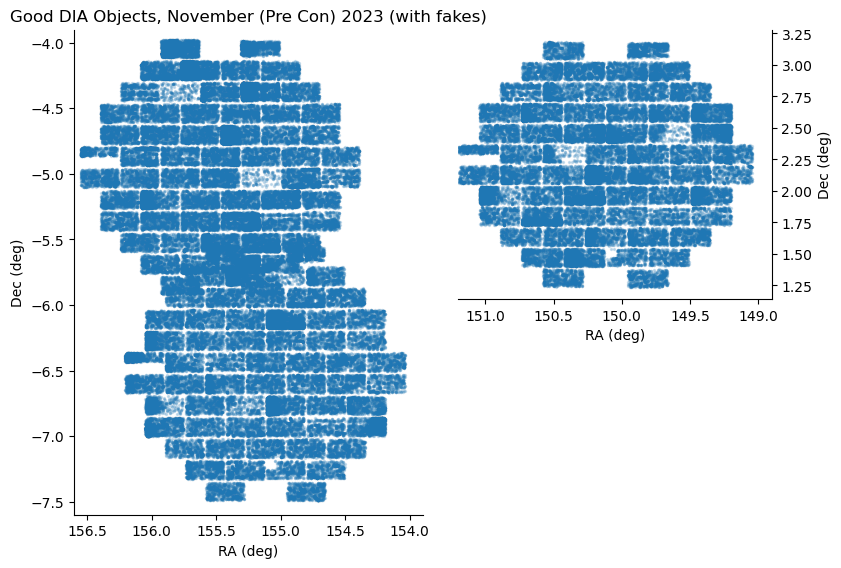

In [14]:
hitsPlot = plac.plotHitsSourcesOnSky(goodObj, title=f'Good DIA Objects, {month} {year} (with fakes)')

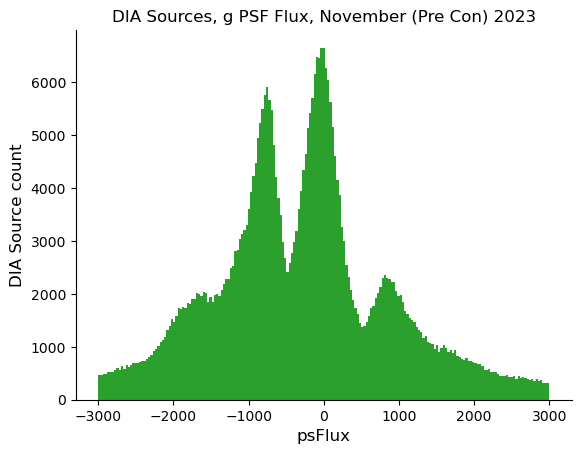

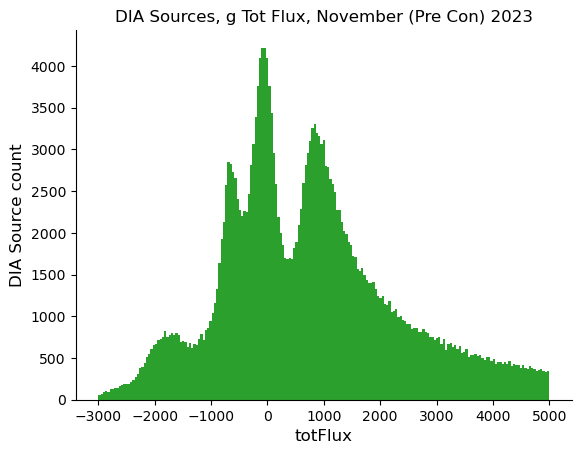

In [15]:
for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} PSF Flux, {month} {year}', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Tot Flux, {month} {year}', color1=color, binmin=-3e3, binmax=5e3)
    # plac.source_magnitude_histogram(repo, goodSrc, band, 'DECam', collection)

## 3. <a id="section_3">Comparison to previous processing run</a>

Good DIA Objects increased slightly, All DIA Objects decreased. Good DIA Sources increased slightly, All DIA Sources decreased. Failures might have caused the sparseness of good objects picked up by certain detectors. Difficult to truly compare everything given the failures.

Text(0.5, 1.0, 'Comparing DIA Object and Source counts (with fakes)')

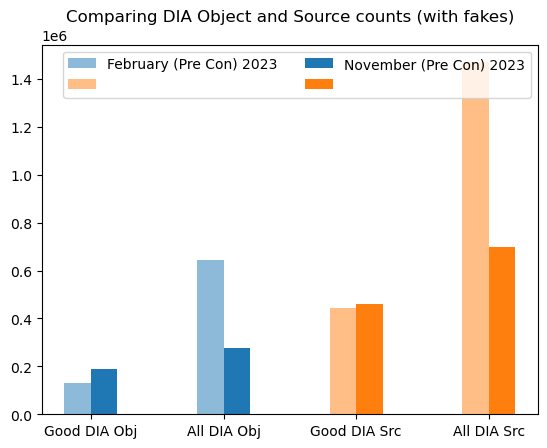

In [16]:
label1 = f'{month_old} {year_old}'
label2 = f'{month} {year}'

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Previous Run
ax.bar(xbar - width/2, [len(goodObj_old), len(objTable_old)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc_old), len(srcTable_old)],
       width, label=' ', color='C1', alpha=0.5)

# Current Run
ax.bar(xbar + width/2, [len(goodObj), len(objTable)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc), len(srcTable)],
       width, label=' ', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts (with fakes)')

Text(0.5, 0.98, 'Good DIA Objects (with fakes)')

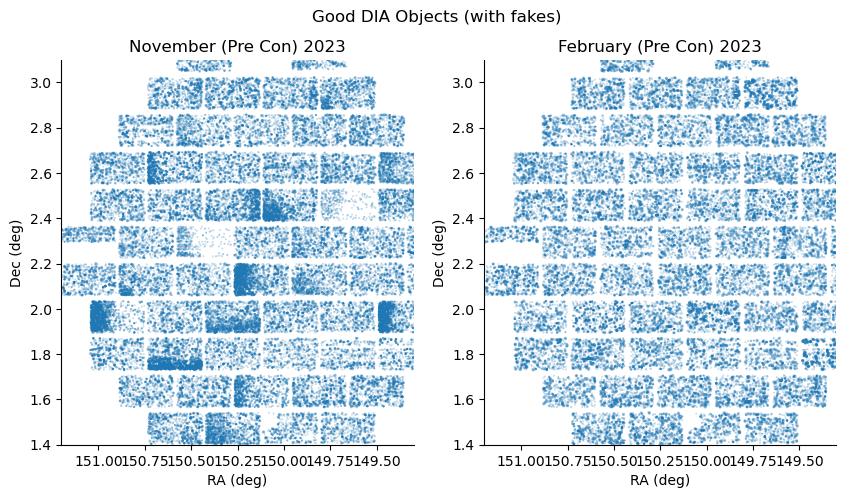

In [17]:
fig = plt.figure(figsize=(10,5))

cutoff = 0  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'dec'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'dec'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle('Good DIA Objects (with fakes)')

Text(0.5, 0.98, 'DIA Objects composed of > 3 "Good" DIA Sources (with fakes)')

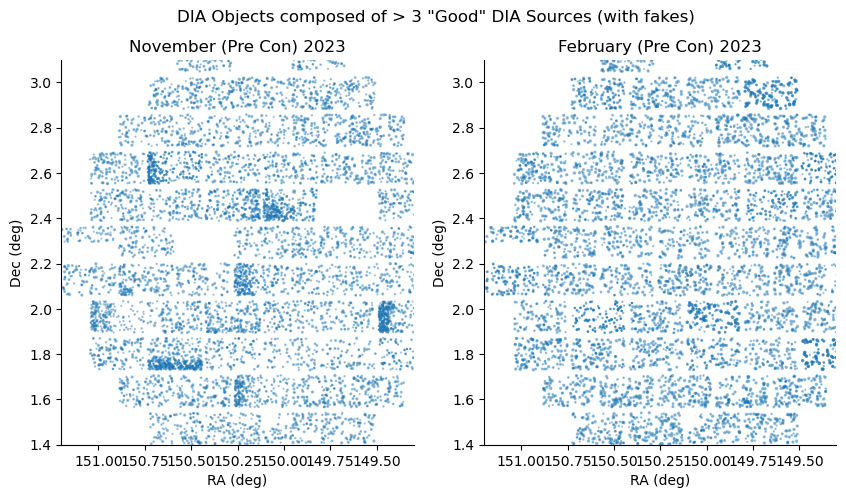

In [18]:
fig = plt.figure(figsize=(10,5))

cutoff = 3  # only plot DIA Objects composed of cutoff or more DIA Sources

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], 
           goodObj.loc[goodObj['nDiaSources'] > cutoff, 'dec'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/3, 
           marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year}')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'ra'], 
            goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'dec'], 
            c='C0', s=goodObj_old.loc[goodObj_old['nDiaSources'] > cutoff, 'nDiaSources']/3, 
            marker='.', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title(f'{month_old} {year_old}')

plt.suptitle(f'DIA Objects composed of > {cutoff} "Good" DIA Sources (with fakes)')

--November (Pre Con) 2023--
Flagged sources: 209237
Unflagged sources: 489418
--February (Pre Con) 2023--
Flagged sources: 822980
Unflagged sources: 646930


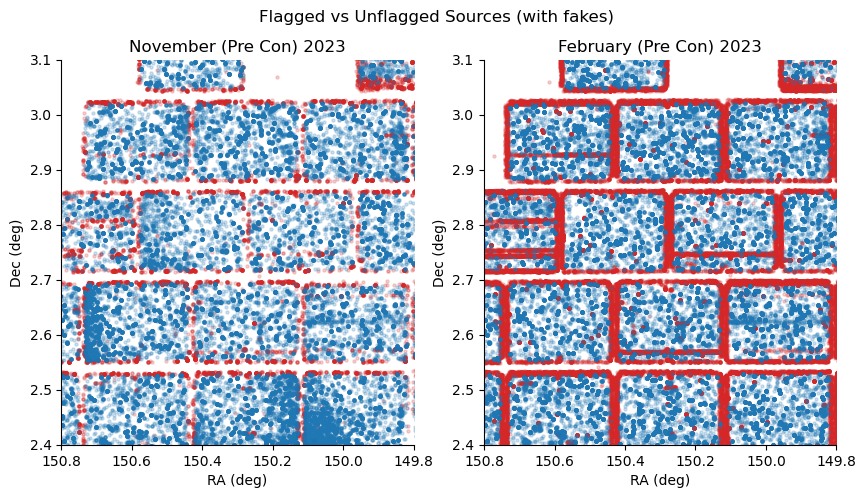

In [19]:
spatial_flag_plot(srcTableFlags, srcTableFlags_old, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title=f'{month} {year}', title2=f'{month_old} {year_old}')

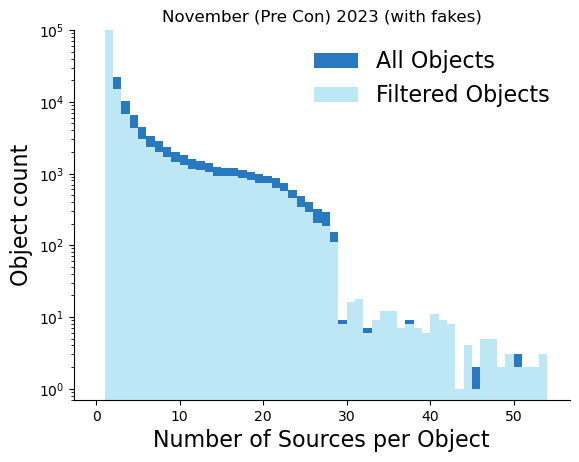

In [20]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year} (with fakes)')

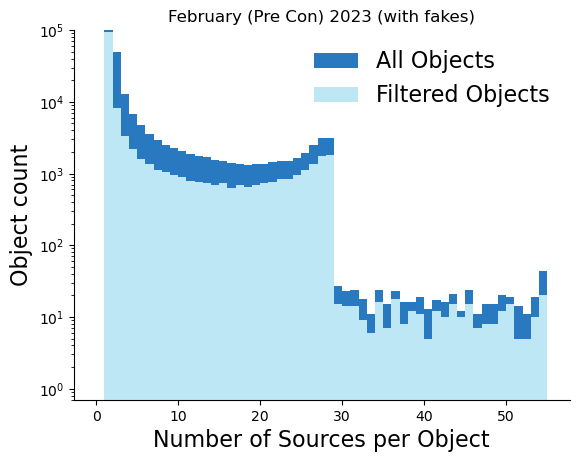

In [21]:
hist = plac.plotDiaObjectHistogram(objTable_old, goodObj_old, title=f'{month_old} {year_old} (with fakes)')

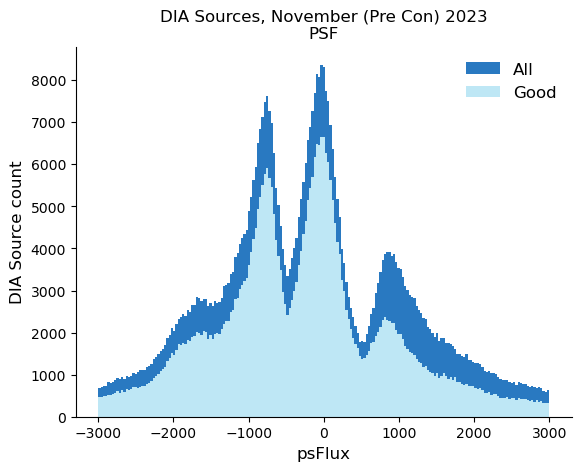

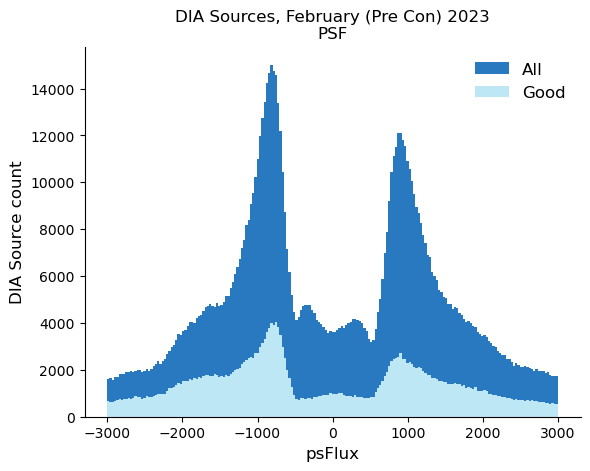

In [22]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nPSF')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='psFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nPSF')

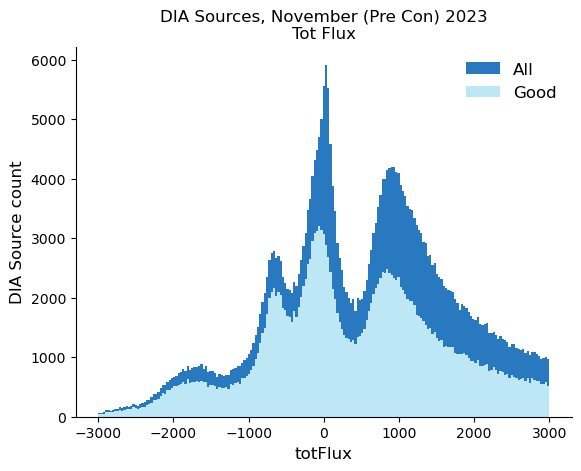

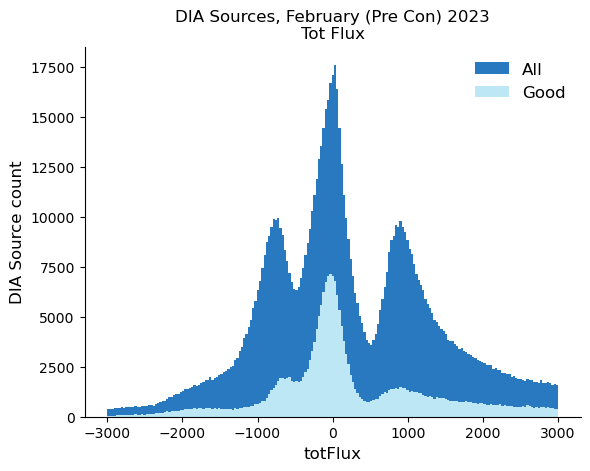

In [23]:
plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month} {year}\nTot Flux')
plac.plotFluxHistSrc(srcTable_old, goodSrc_old, fluxType='totFlux', label1='All', label2='Good',
                title=f'DIA Sources, {month_old} {year_old}\nTot Flux')

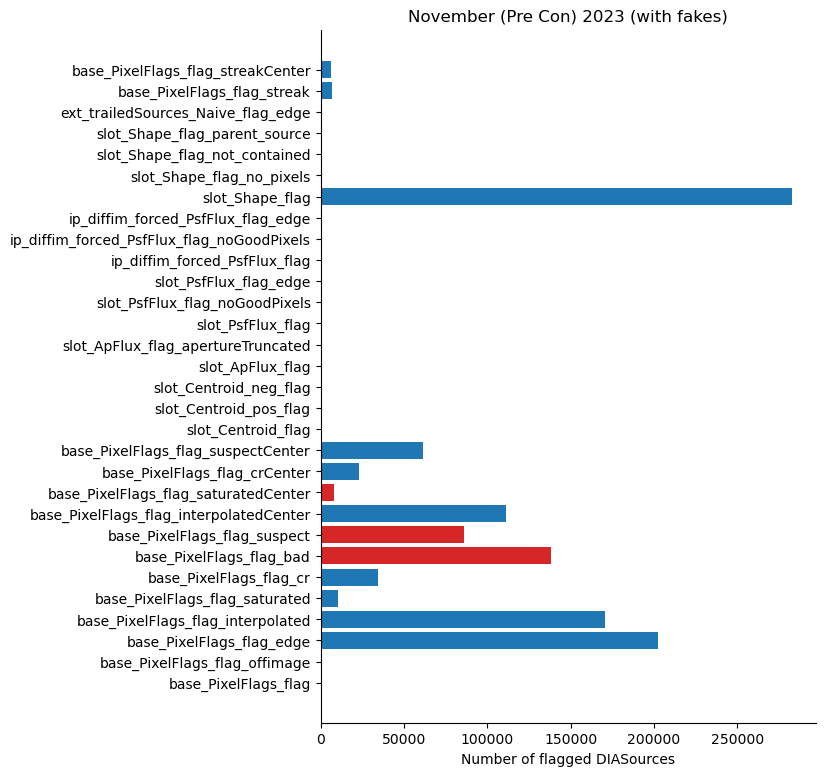

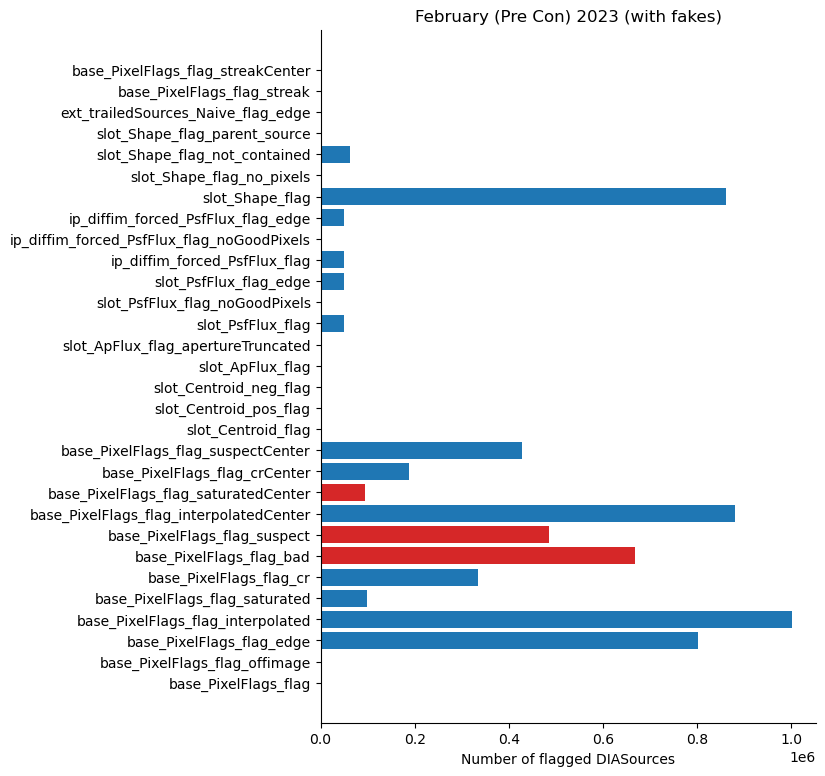

In [24]:
plac.plotFlagHist(srcTable, title=f'{month} {year} (with fakes)')
plac.plotFlagHist(srcTable_old, title=f'{month_old} {year_old} (with fakes)')

### By the numbers

In [25]:
nGoodObj = len(goodObj)
nGoodObj_old = len(goodObj_old)

print(f"{month} {year}, Number of good objects: ",nGoodObj)
print(f"{month_old} {year_old}, Number of good objects: ",nGoodObj_old)

print("Diff: ", nGoodObj-nGoodObj_old)

November (Pre Con) 2023, Number of good objects:  191152
February (Pre Con) 2023, Number of good objects:  131435
Diff:  59717


In [26]:
nObj = len(objTable)
nObj_old = len(objTable_old)

print(f"{month} {year}, Number of objects: ",nObj)
print(f"{month_old} {year_old}, Number of objects: ",nObj_old)

print("Diff: ", nObj-nObj_old)

November (Pre Con) 2023, Number of objects:  275870
February (Pre Con) 2023, Number of objects:  645653
Diff:  -369783


In [27]:
nGoodSrc = len(goodSrc)
nGoodSrc_old = len(goodSrc_old)

print(f"{month} {year}, Number of good sources: ",nGoodSrc)
print(f"{month_old} {year_old}, Number of good sources: ",nGoodSrc_old)

print("Diff: ", nGoodSrc-nGoodSrc_old)

November (Pre Con) 2023, Number of good sources:  460596
February (Pre Con) 2023, Number of good sources:  444994
Diff:  15602


In [28]:
nSrc = len(srcTable)
nSrc_old = len(srcTable_old)

print(f"{month} {year}, Number of sources: ",nSrc)
print(f"{month_old} {year_old}, Number of sources: ",nSrc_old)

print("Diff: ", nSrc-nSrc_old)

November (Pre Con) 2023, Number of sources:  698655
February (Pre Con) 2023, Number of sources:  1469910
Diff:  -771255


In [29]:
flagSum = flagTable.sum()
flagSum_old = flagTable_old.sum()

print(f"Difference between {month} {year} run and {month_old} {year_old} run, ordered:")
flagSum.subtract(flagSum_old).sort_values()

Difference between November (Pre Con) 2023 run and February (Pre Con) 2023 run, ordered:


base_PixelFlags_flag_interpolated            -830778
base_PixelFlags_flag_interpolatedCenter      -769558
base_PixelFlags_flag_edge                    -599438
slot_Shape_flag                              -578191
base_PixelFlags_flag_bad                     -529127
base_PixelFlags_flag_suspect                 -398417
base_PixelFlags_flag_suspectCenter           -365868
base_PixelFlags_flag_cr                      -299551
base_PixelFlags_flag_crCenter                -165473
base_PixelFlags_flag_saturated                -87838
base_PixelFlags_flag_saturatedCenter          -85956
slot_Shape_flag_not_contained                 -63246
slot_PsfFlux_flag                             -48796
ip_diffim_forced_PsfFlux_flag                 -48492
slot_PsfFlux_flag_edge                        -48431
ip_diffim_forced_PsfFlux_flag_edge            -48416
slot_ApFlux_flag                                -978
slot_ApFlux_flag_apertureTruncated              -831
base_PixelFlags_flag_offimage                 

## 4. <a id="section_4">Separating the fake sources from the real sources</a>

Something went wrong with fakes matching, like with DM-37699.

In [30]:
allInjectedFakes = butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=9813, storageClass='ArrowAstropy')
allInjectedFakes['ra'] = (allInjectedFakes['ra']*u.radian).to(u.deg)
allInjectedFakes['dec']= (allInjectedFakes['dec']*u.radian).to(u.deg)

In [31]:
diaSource = butler.get('fakes_goodSeeingDiff_diaSrcTable', collections=collections,
                 instrument=instrument, detector=20, visit=419791, skymap=skymap, storageClass='ArrowAstropy')

In [32]:
from astropy.table import Table
from lsst.analysis.tools.tasks.catalogMatch import CatalogMatchTask

t1 = Table()
t1["ra_steven"] = [1,2]
t1["dec_manuel"] = [1,2]

t2 = Table()
t2["ra"] = [1,2]
t2["dec"] = [1,2]

CMT = CatalogMatchTask()
CMT.config.selectorBands = []
CMT.config.targetRaColumn = "ra"
CMT.config.targetDecColumn = "dec"
CMT.config.refRaColumn = "ra"
CMT.config.refDecColumn = "dec"                                      

matchedCat = CMT.run(targetCatalog=allInjectedFakes, refCatalog=diaSource, bands=[])
print(matchedCat)

Struct(matchedCatalog=fakeId_target dec_target ra_target ... __index_level_0___ref matchDistance
                 deg        deg    ...                                    
------------- ---------- --------- ... --------------------- -------------)


## 5. <a id="section_5">Fakes completeness analysis</a>

Skipping due to the issue with matched fakes.

## 6. <a id="section_6">SNR distributions</a>

Similar spreads and shapes as previous pre con run, but with fewer sources due to failed quanta.

Text(0.5, 0, 'SNR of DIA Sources')

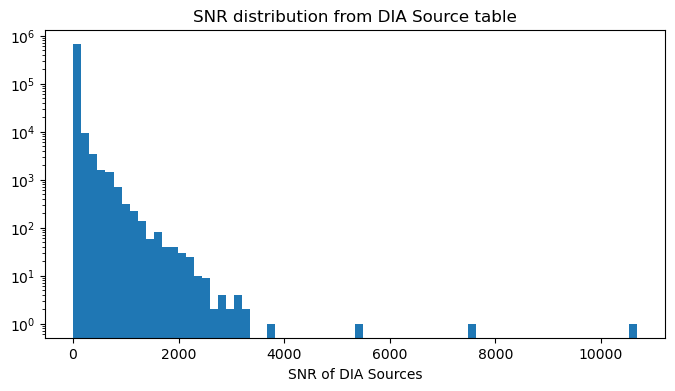

In [33]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable.snr, bins=70)
plt.title('SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')

In [34]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

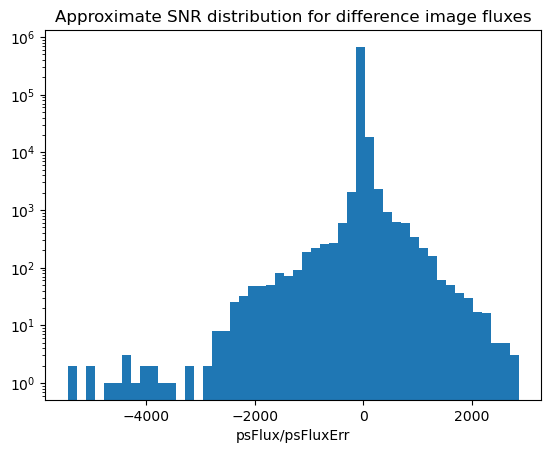

In [35]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title('Approximate SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

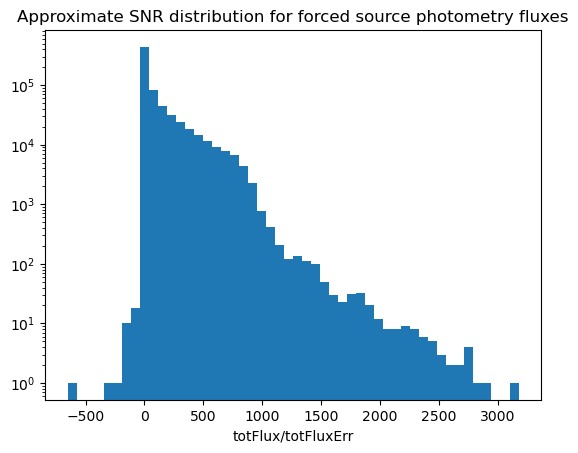

In [36]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title('Approximate SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')